
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh 

____

# 🔴 **Import Libs**

In [50]:
!python -m pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.2.0+cu118
Uninstalling torch-2.2.0+cu118:
  Successfully uninstalled torch-2.2.0+cu118


You can safely remove it manually.


In [51]:
!python -m pip install --upgrade torch==2.2.0+cu118 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.2.0%2Bcu118-cp310-cp310-win_amd64.whl (2704.3 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [52]:
import torch
torch.__version__

'2.2.0+cu118'

In [53]:
!pip install --upgrade torchdata
!pip install --upgrade torchtext --index-url https://download.pytorch.org/whl/cu118
!pip install torchmetrics

  Using cached torchdata-0.10.1-py3-none-any.whl.metadata (6.3 kB)
Using cached torchdata-0.10.1-py3-none-any.whl (57 kB)
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.7.1
    Uninstalling torchdata-0.7.1:
      Successfully uninstalled torchdata-0.7.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.16.2+cpu requires torchdata==0.7.1, but you have torchdata 0.10.1 which is incompatible.


Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/torchdata-0.7.1-py3-none-any.whl (184 kB)
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.10.1
    Uninstalling torchdata-0.10.1:
      Successfully uninstalled torchdata-0.10.1


In [54]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext
import torchdata

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

In [55]:
!python --version
print(torch.__version__)
print(torchtext.__version__)
print(torchdata.__version__)

Python 3.10.10
2.2.0+cu118
0.17.0+cpu
0.7.1


In [56]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.3
torch --> 2.2.0+cu118
torchtext --> 0.17.0+cpu
tqdm --> 4.67.1


# 🔴 **Utils**

In [57]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [58]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [59]:
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']
print(train_data[1]) 

{'text': ' = Valkyria Chronicles III = \n'}


## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [60]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def yield_tokens(dataset_split):
    for example in dataset_split:
        yield tokenizer(example["text"])

train_tokens = yield_tokens(train_data)

vocab = build_vocab_from_iterator(train_tokens, specials=["<unk>", "<pad>", "<bos>", "<eos>"])
vocab.set_default_index(vocab["<unk>"])

print("Special Tokens and Their Indices:")
print(f"<unk>: {vocab['<unk>']}")
print(f"<pad>: {vocab['<pad>']}")
print(f"<bos>: {vocab['<bos>']}")
print(f"<eos>: {vocab['<eos>']}")


sample_text = "This is an example sentence."
tokenized_text = tokenizer(sample_text)
indexed_text = [vocab[token] for token in tokenized_text]

print("\nTokenized Text:", tokenized_text)
print("Indexed Text:", indexed_text)

Special Tokens and Their Indices:
<unk>: 0
<pad>: 1
<bos>: 2
<eos>: 3

Tokenized Text: ['this', 'is', 'an', 'example', 'sentence', '.']
Indexed Text: [38, 26, 33, 619, 2140, 6]


## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [61]:
def calculate_statistics(dataset_split):
    num_documents = len(dataset_split)
    total_words = 0
    total_lengths = []

    for doc in dataset_split:
        tokens = tokenizer(doc["text"])
        total_words += len(tokens)
        total_lengths.append(len(tokens))

    avg_doc_length = total_words / num_documents if num_documents > 0 else 0

    return {
        "num_documents": num_documents,
        "total_words": total_words,
        "avg_doc_length": avg_doc_length,
        "min_doc_length": min(total_lengths) if total_lengths else 0,
        "max_doc_length": max(total_lengths) if total_lengths else 0,
    }

train_stats = calculate_statistics(train_data)
print("Training Set Statistics:")
for stat, value in train_stats.items():
    print(f"{stat}: {value}")

Training Set Statistics:
num_documents: 36718
total_words: 2051665
avg_doc_length: 55.87627321749551
min_doc_length: 0
max_doc_length: 696


### 🟡 Analyze the most common and least common words in the dataset.

In [62]:
from collections import Counter

def count_words(dataset_split):
    word_counter = Counter()

    for doc in dataset_split:
        tokens = tokenizer(doc["text"])
        word_counter.update(tokens)

    return word_counter

train_word_counts = count_words(train_data)
most_common_words = train_word_counts.most_common(10)
least_common_words = [word for word, count in train_word_counts.items() if count == 1]

print("Most Common Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

print("\nNumber of Least Common Words (occurring once):", len(least_common_words))
print("Example of Least Common Words:", least_common_words[:10])


Most Common Words:
the: 130770
,: 102624
.: 84291
of: 57032
and: 50736
in: 45018
to: 39522
a: 36564
=: 29570
was: 21008

Number of Least Common Words (occurring once): 26924
Example of Least Common Words: ['calamaty', 'forgiving', 'unvoiced', 'scanned', 'boosts', 'depleting', 'reila', 'shocktroopers', 'thereon', 'altaha']


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

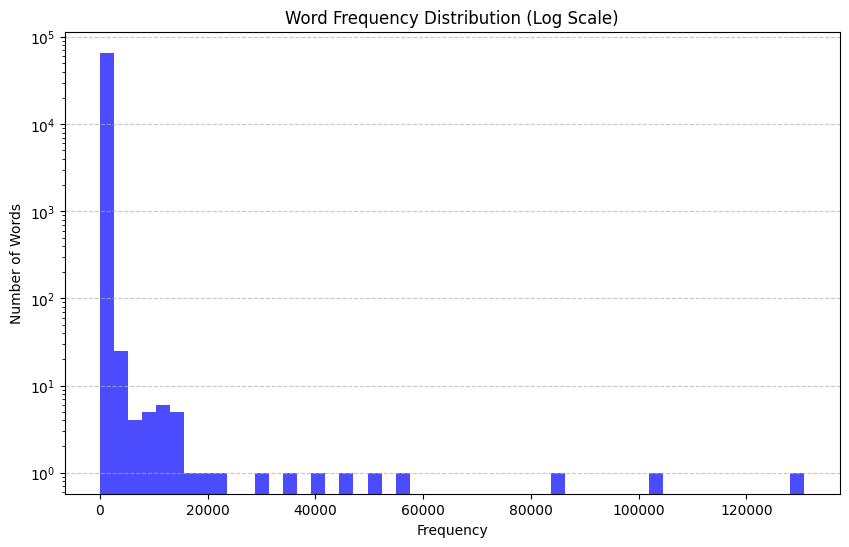

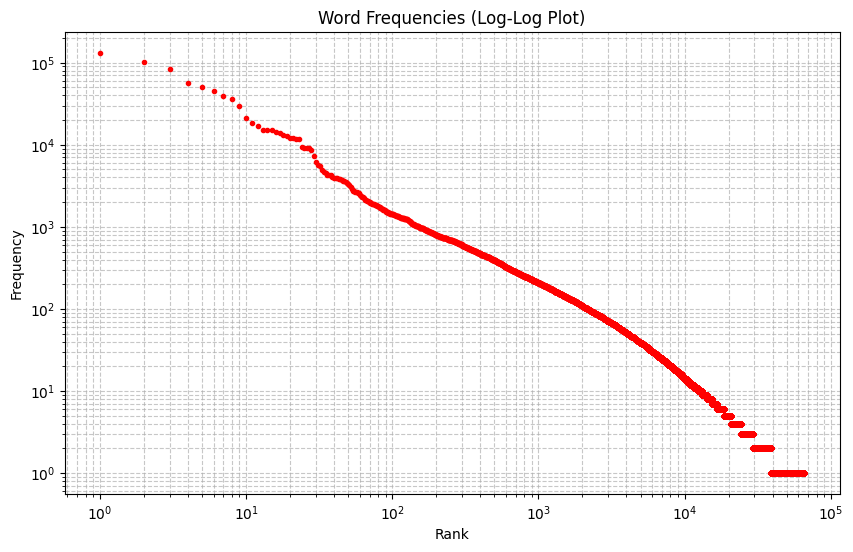

In [63]:
word_frequencies = np.array(list(train_word_counts.values()))

plt.figure(figsize=(10, 6))
plt.hist(word_frequencies, bins=50, log=True, color='blue', alpha=0.7)
plt.title("Word Frequency Distribution (Log Scale)")
plt.xlabel("Frequency")
plt.ylabel("Number of Words")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

sorted_frequencies = np.sort(word_frequencies)[::-1]
ranks = np.arange(1, len(sorted_frequencies) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_frequencies, marker="o", linestyle="", markersize=3, color='red')
plt.title("Word Frequencies (Log-Log Plot)")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.grid(which='both', linestyle='--', alpha=0.7)
plt.show()

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [64]:
from torch.nn.utils.rnn import pad_sequence

def data_process(raw_text_iter, batch_size, seq_len, vocab, tokenizer):
    tokens = []
    for line in raw_text_iter:
        tokens.extend(tokenizer(line))
    
    token_indices = torch.tensor([vocab[token] for token in tokens if token in vocab])
    
    total_tokens = len(token_indices)
    num_samples = total_tokens // seq_len
    token_indices = token_indices[:num_samples * seq_len]
    data = token_indices.clone().detach().view(num_samples, seq_len)

    inputs = data[:, :-1]
    targets = data[:, 1:]
    return inputs, targets

In [65]:
batch_size = 32
seq_len = 50

train_raw_iter = (line["text"] for line in train_data)
val_raw_iter = (line["text"] for line in val_data)
test_raw_iter = (line["text"] for line in test_data)

train_inputs, train_targets = data_process(train_raw_iter, batch_size, seq_len, vocab, tokenizer)
val_inputs, val_targets = data_process(val_raw_iter, batch_size, seq_len, vocab, tokenizer)
test_inputs, test_targets = data_process(test_raw_iter, batch_size, seq_len, vocab, tokenizer)

print("Inputs shape (N x B x L):", train_inputs.shape)
print("Targets shape (N x B x L):", train_targets.shape)


Inputs shape (N x B x L): torch.Size([41033, 49])
Targets shape (N x B x L): torch.Size([41033, 49])


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [66]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]


In [67]:
train_dataset = LanguageModelDataset(train_inputs, train_targets)
val_dataset = LanguageModelDataset(val_inputs, val_targets)
test_dataset = LanguageModelDataset(test_inputs, test_targets)

print(f"Dataset length: {len(train_dataset)}")
print("Sample input-target pair:")
print(train_dataset[0])

Dataset length: 41033
Sample input-target pair:
(tensor([   12,  3874,  3890,   885,    12, 20488,    86,  3874,    90, 24097,
         3890,    24,   785, 29473,     5,  6081,     6,  3874,     7,     4,
         5054,    90,    23,     5,  1840,  1016,    10,    17,  3874,  3890,
          885,   634,   980,     5,    26,    11,  5692,   303,    15,   578,
          235,    70,   456,    22, 14003,     8,   758,     6,  2476]), tensor([ 3874,  3890,   885,    12, 20488,    86,  3874,    90, 24097,  3890,
           24,   785, 29473,     5,  6081,     6,  3874,     7,     4,  5054,
           90,    23,     5,  1840,  1016,    10,    17,  3874,  3890,   885,
          634,   980,     5,    26,    11,  5692,   303,    15,   578,   235,
           70,   456,    22, 14003,     8,   758,     6,  2476,    20]))


## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [68]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [69]:
class LanguageModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super(LanguageModel, self).__init__()
      
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(
        input_size=embedding_dim,
        hidden_size=hidden_dim,
        num_layers=num_layers,
        dropout=dropout_rate,
        batch_first=True
    )
    self.fc = nn.Linear(hidden_dim, vocab_size)
    self.dropout = nn.Dropout(dropout_rate)
    

  def forward(self, src):
    embedded = self.embedding(src)
    lstm_out, _ = self.lstm(embedded)
    lstm_out = self.dropout(lstm_out)
    output = self.fc(lstm_out)
    return output

In [70]:
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_rate = 0.5

model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
print(model)

src, _ = next(iter(train_loader))
output = model(src)
print("Output shape:", output.shape)

LanguageModel(
  (embedding): Embedding(66061, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=66061, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Output shape: torch.Size([32, 49, 66061])


# 🔴 **Config**

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [72]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
accuracy = tm.Accuracy(task="multiclass", num_classes=vocab_size).to(device)
perplexity = tm.text.Perplexity().to(device)

print("Model Summary:")
print(model)
print(f"Optimizer: {optimizer}")
print(f"Loss Function: {criterion}")
print(f"Metric: {perplexity}")

Model Summary:
LanguageModel(
  (embedding): Embedding(66061, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=66061, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Loss Function: CrossEntropyLoss()
Metric: Perplexity()


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [73]:
scaler = torch.cuda.amp.GradScaler()

def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
        
      outputs_2d = outputs.view(-1, outputs.size(-1))  
      targets_2d = targets.view(-1)

      loss = loss_fn(outputs_2d, targets_2d)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
        
      logit = F.log_softmax(outputs, dim=-1)
      metric.update(logit, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [74]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
        
      outputs_2d = outputs.view(-1, outputs.size(-1))  
      targets_2d = targets.view(-1) 

      loss = loss_fn(outputs_2d, targets_2d)
      loss_eval.update(loss.item(), n=len(targets))

      logit = F.log_softmax(outputs, dim=-1)
      metric.update(logit, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [75]:
model = model.to(device)
model.eval()

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  
  outputs_2d = outputs.view(-1, outputs.size(-1))  
  targets_2d = targets.view(-1) 
    
  print(outputs.shape, targets.shape)
    
  loss = criterion(outputs_2d, targets_2d)

print(loss)

torch.Size([32, 49, 66061]) torch.Size([32, 49])
tensor(11.1054, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [76]:
model = model.to(device)

In [77]:
train_subset = torch.utils.data.Subset(train_dataset, indices=range(256))
train_subset_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

In [78]:
num_epochs = 30

for epoch in range(num_epochs):
  model, train_loss, train_perplexity = train_one_epoch(model, train_subset_loader, criterion, optimizer, perplexity, epoch)
  val_loss, val_perplexity = evaluate(model, val_loader, criterion, perplexity)

  print(f"Epoch {epoch} -- Train Loss: {train_loss:.4f} -- Train Perplexity: {train_perplexity:.4f} -- Val Loss: {val_loss:.4f} -- Val Perplexity: {val_perplexity:.4f}")

100%|██████████| 8/8 [00:00<00:00, 15.26batch/s, loss=11, metric=5.82e+4]  


Epoch 0 -- Train Loss: 10.9711 -- Train Perplexity: 58168.3711 -- Val Loss: 10.2755 -- Val Perplexity: 29012.2266


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 16.97batch/s, loss=8.77, metric=6.46e+3]


Epoch 1 -- Train Loss: 8.7740 -- Train Perplexity: 6463.9775 -- Val Loss: 8.0545 -- Val Perplexity: 3147.8948


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 17.04batch/s, loss=6.99, metric=1.08e+3]


Epoch 2 -- Train Loss: 6.9855 -- Train Perplexity: 1080.8254 -- Val Loss: 8.0620 -- Val Perplexity: 3171.6099


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 17.37batch/s, loss=6.74, metric=848]


Epoch 3 -- Train Loss: 6.7427 -- Train Perplexity: 847.8631 -- Val Loss: 8.3045 -- Val Perplexity: 4041.9229


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 17.29batch/s, loss=6.63, metric=760]


Epoch 4 -- Train Loss: 6.6327 -- Train Perplexity: 759.5587 -- Val Loss: 8.3898 -- Val Perplexity: 4401.8408


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 17.27batch/s, loss=6.56, metric=703]


Epoch 5 -- Train Loss: 6.5553 -- Train Perplexity: 702.9628 -- Val Loss: 8.4198 -- Val Perplexity: 4536.1465


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 17.10batch/s, loss=6.52, metric=676]


Epoch 6 -- Train Loss: 6.5164 -- Train Perplexity: 676.1127 -- Val Loss: 8.4325 -- Val Perplexity: 4593.9878


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 17.18batch/s, loss=6.49, metric=656]


Epoch 7 -- Train Loss: 6.4868 -- Train Perplexity: 656.4409 -- Val Loss: 8.4570 -- Val Perplexity: 4707.8403


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.18batch/s, loss=6.47, metric=643]


Epoch 8 -- Train Loss: 6.4658 -- Train Perplexity: 642.7822 -- Val Loss: 8.4855 -- Val Perplexity: 4844.1870


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 17.12batch/s, loss=6.47, metric=644]


Epoch 9 -- Train Loss: 6.4670 -- Train Perplexity: 643.5726 -- Val Loss: 8.5078 -- Val Perplexity: 4953.0610


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 15.54batch/s, loss=6.44, metric=626]


Epoch 10 -- Train Loss: 6.4393 -- Train Perplexity: 625.9858 -- Val Loss: 8.5363 -- Val Perplexity: 5096.3975


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 17.14batch/s, loss=6.44, metric=629]


Epoch 11 -- Train Loss: 6.4442 -- Train Perplexity: 629.0289 -- Val Loss: 8.5606 -- Val Perplexity: 5222.0542


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 17.09batch/s, loss=6.44, metric=628]


Epoch 12 -- Train Loss: 6.4427 -- Train Perplexity: 628.0734 -- Val Loss: 8.5845 -- Val Perplexity: 5348.3540


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 17.07batch/s, loss=6.42, metric=615]


Epoch 13 -- Train Loss: 6.4212 -- Train Perplexity: 614.7684 -- Val Loss: 8.6116 -- Val Perplexity: 5494.9863


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 17.10batch/s, loss=6.42, metric=614]


Epoch 14 -- Train Loss: 6.4201 -- Train Perplexity: 614.0538 -- Val Loss: 8.6369 -- Val Perplexity: 5636.0195


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.25batch/s, loss=6.42, metric=613]


Epoch 15 -- Train Loss: 6.4191 -- Train Perplexity: 613.4515 -- Val Loss: 8.6542 -- Val Perplexity: 5734.0132


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 17.32batch/s, loss=6.42, metric=616]


Epoch 16 -- Train Loss: 6.4229 -- Train Perplexity: 615.7800 -- Val Loss: 8.6721 -- Val Perplexity: 5837.9302


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 17.19batch/s, loss=6.4, metric=605] 


Epoch 17 -- Train Loss: 6.4050 -- Train Perplexity: 604.8582 -- Val Loss: 8.6919 -- Val Perplexity: 5954.5718


Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 17.30batch/s, loss=6.4, metric=603] 


Epoch 18 -- Train Loss: 6.4019 -- Train Perplexity: 602.9970 -- Val Loss: 8.7090 -- Val Perplexity: 6057.4692


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 17.23batch/s, loss=6.39, metric=598]


Epoch 19 -- Train Loss: 6.3934 -- Train Perplexity: 597.8724 -- Val Loss: 8.7340 -- Val Perplexity: 6210.2021


Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 17.19batch/s, loss=6.39, metric=595]


Epoch 20 -- Train Loss: 6.3894 -- Train Perplexity: 595.4946 -- Val Loss: 8.7544 -- Val Perplexity: 6338.7417


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 17.32batch/s, loss=6.38, metric=592]


Epoch 21 -- Train Loss: 6.3843 -- Train Perplexity: 592.4435 -- Val Loss: 8.7655 -- Val Perplexity: 6409.5410


Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 17.33batch/s, loss=6.38, metric=591]


Epoch 22 -- Train Loss: 6.3823 -- Train Perplexity: 591.2908 -- Val Loss: 8.7819 -- Val Perplexity: 6514.9922


Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 17.17batch/s, loss=6.37, metric=587]


Epoch 23 -- Train Loss: 6.3747 -- Train Perplexity: 586.8184 -- Val Loss: 8.8077 -- Val Perplexity: 6685.6470


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 17.08batch/s, loss=6.37, metric=585]


Epoch 24 -- Train Loss: 6.3723 -- Train Perplexity: 585.3799 -- Val Loss: 8.8110 -- Val Perplexity: 6707.7886


Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 17.08batch/s, loss=6.37, metric=584]


Epoch 25 -- Train Loss: 6.3701 -- Train Perplexity: 584.1035 -- Val Loss: 8.8186 -- Val Perplexity: 6758.4717


Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 14.84batch/s, loss=6.36, metric=578]


Epoch 26 -- Train Loss: 6.3604 -- Train Perplexity: 578.4563 -- Val Loss: 8.8296 -- Val Perplexity: 6833.7505


Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 17.15batch/s, loss=6.35, metric=572]


Epoch 27 -- Train Loss: 6.3484 -- Train Perplexity: 571.5699 -- Val Loss: 8.8498 -- Val Perplexity: 6972.8818


Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 17.02batch/s, loss=6.35, metric=573]


Epoch 28 -- Train Loss: 6.3506 -- Train Perplexity: 572.8490 -- Val Loss: 8.8595 -- Val Perplexity: 7040.7056


Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 17.07batch/s, loss=6.35, metric=573]


Epoch 29 -- Train Loss: 6.3505 -- Train Perplexity: 572.7859 -- Val Loss: 8.8658 -- Val Perplexity: 7085.1685


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [79]:
num_epochs = 10

for lr in [1e-2, 1e-3, 1e-4]:
  print(f'LR={lr}')

  model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  perplexity = tm.text.Perplexity().to(device)

  for epoch in range(num_epochs):
    model, train_loss, train_perplexity = train_one_epoch(model, train_loader, criterion, optimizer, perplexity, epoch)
    val_loss, val_perplexity = evaluate(model, val_loader, criterion, perplexity)

    print(f"Epoch {epoch} -- Train Loss: {train_loss:.4f} -- Train Perplexity: {train_perplexity:.4f} -- Val Loss: {val_loss:.4f} -- Val Perplexity: {val_perplexity:.4f}")

  print(f"Val Perplexity: {val_perplexity:.4f}")

LR=0.01


100%|██████████| 1283/1283 [01:08<00:00, 18.69batch/s, loss=11, metric=5.8e+4]  


Epoch 0 -- Train Loss: 10.9676 -- Train Perplexity: 57967.2383 -- Val Loss: 10.7229 -- Val Perplexity: 45385.6328


Epoch 1: 100%|██████████| 1283/1283 [01:10<00:00, 18.18batch/s, loss=9.51, metric=1.35e+4]


Epoch 1 -- Train Loss: 9.5120 -- Train Perplexity: 13520.8945 -- Val Loss: 8.5488 -- Val Perplexity: 5160.3589


Epoch 2: 100%|██████████| 1283/1283 [01:10<00:00, 18.26batch/s, loss=8.5, metric=4.9e+3]  


Epoch 2 -- Train Loss: 8.4974 -- Train Perplexity: 4901.9663 -- Val Loss: 8.1728 -- Val Perplexity: 3543.3633


Epoch 3: 100%|██████████| 1283/1283 [01:10<00:00, 18.29batch/s, loss=8.26, metric=3.87e+3]


Epoch 3 -- Train Loss: 8.2607 -- Train Perplexity: 3868.7581 -- Val Loss: 7.9901 -- Val Perplexity: 2951.5188


Epoch 4: 100%|██████████| 1283/1283 [01:10<00:00, 18.24batch/s, loss=8.11, metric=3.34e+3]


Epoch 4 -- Train Loss: 8.1127 -- Train Perplexity: 3336.5984 -- Val Loss: 7.8561 -- Val Perplexity: 2581.4468


Epoch 5: 100%|██████████| 1283/1283 [01:10<00:00, 18.20batch/s, loss=8, metric=2.98e+3]   


Epoch 5 -- Train Loss: 8.0007 -- Train Perplexity: 2982.9885 -- Val Loss: 7.7500 -- Val Perplexity: 2321.5857


Epoch 6: 100%|██████████| 1283/1283 [01:11<00:00, 18.03batch/s, loss=7.91, metric=2.73e+3]


Epoch 6 -- Train Loss: 7.9130 -- Train Perplexity: 2732.5906 -- Val Loss: 7.6658 -- Val Perplexity: 2134.0090


Epoch 7: 100%|██████████| 1283/1283 [01:09<00:00, 18.35batch/s, loss=7.84, metric=2.54e+3]


Epoch 7 -- Train Loss: 7.8414 -- Train Perplexity: 2543.7859 -- Val Loss: 7.5949 -- Val Perplexity: 1988.1005


Epoch 8: 100%|██████████| 1283/1283 [01:10<00:00, 18.11batch/s, loss=7.78, metric=2.39e+3]


Epoch 8 -- Train Loss: 7.7800 -- Train Perplexity: 2392.3071 -- Val Loss: 7.5340 -- Val Perplexity: 1870.5878


Epoch 9: 100%|██████████| 1283/1283 [01:09<00:00, 18.36batch/s, loss=7.73, metric=2.27e+3]


Epoch 9 -- Train Loss: 7.7261 -- Train Perplexity: 2266.7847 -- Val Loss: 7.4814 -- Val Perplexity: 1774.6873
Val Perplexity: 1774.6873
LR=0.001


100%|██████████| 1283/1283 [01:09<00:00, 18.49batch/s, loss=11.1, metric=6.57e+4]


Epoch 0 -- Train Loss: 11.0932 -- Train Perplexity: 65725.2109 -- Val Loss: 11.0814 -- Val Perplexity: 64953.9805


Epoch 1: 100%|██████████| 1283/1283 [01:10<00:00, 18.10batch/s, loss=11.1, metric=6.43e+4]


Epoch 1 -- Train Loss: 11.0717 -- Train Perplexity: 64324.8945 -- Val Loss: 11.0585 -- Val Perplexity: 63478.3711


Epoch 2: 100%|██████████| 1283/1283 [01:10<00:00, 18.09batch/s, loss=11, metric=6.29e+4]  


Epoch 2 -- Train Loss: 11.0495 -- Train Perplexity: 62910.1211 -- Val Loss: 11.0346 -- Val Perplexity: 61979.1055


Epoch 3: 100%|██████████| 1283/1283 [01:11<00:00, 17.97batch/s, loss=11, metric=6.15e+4]


Epoch 3 -- Train Loss: 11.0261 -- Train Perplexity: 61456.8555 -- Val Loss: 11.0091 -- Val Perplexity: 60422.4023


Epoch 4: 100%|██████████| 1283/1283 [01:10<00:00, 18.21batch/s, loss=11, metric=5.99e+4]


Epoch 4 -- Train Loss: 11.0010 -- Train Perplexity: 59932.5273 -- Val Loss: 10.9814 -- Val Perplexity: 58768.7344


Epoch 5: 100%|██████████| 1283/1283 [01:10<00:00, 18.08batch/s, loss=11, metric=5.83e+4]


Epoch 5 -- Train Loss: 10.9731 -- Train Perplexity: 58286.4844 -- Val Loss: 10.9501 -- Val Perplexity: 56959.1406


Epoch 6: 100%|██████████| 1283/1283 [01:10<00:00, 18.15batch/s, loss=10.9, metric=5.65e+4]


Epoch 6 -- Train Loss: 10.9412 -- Train Perplexity: 56458.8867 -- Val Loss: 10.9135 -- Val Perplexity: 54911.1250


Epoch 7: 100%|██████████| 1283/1283 [01:10<00:00, 18.11batch/s, loss=10.9, metric=5.43e+4]


Epoch 7 -- Train Loss: 10.9030 -- Train Perplexity: 54339.2852 -- Val Loss: 10.8684 -- Val Perplexity: 52490.3867


Epoch 8: 100%|██████████| 1283/1283 [01:10<00:00, 18.18batch/s, loss=10.9, metric=5.18e+4]


Epoch 8 -- Train Loss: 10.8545 -- Train Perplexity: 51766.6211 -- Val Loss: 10.8091 -- Val Perplexity: 49469.0312


Epoch 9: 100%|██████████| 1283/1283 [01:10<00:00, 18.14batch/s, loss=10.8, metric=4.84e+4]


Epoch 9 -- Train Loss: 10.7880 -- Train Perplexity: 48437.3164 -- Val Loss: 10.7238 -- Val Perplexity: 45425.4297
Val Perplexity: 45425.4297
LR=0.0001


100%|██████████| 1283/1283 [01:09<00:00, 18.47batch/s, loss=11.1, metric=6.68e+4]


Epoch 0 -- Train Loss: 11.1098 -- Train Perplexity: 66820.3047 -- Val Loss: 11.1089 -- Val Perplexity: 66760.6172


Epoch 1: 100%|██████████| 1283/1283 [01:09<00:00, 18.34batch/s, loss=11.1, metric=6.67e+4]


Epoch 1 -- Train Loss: 11.1076 -- Train Perplexity: 66674.5938 -- Val Loss: 11.1066 -- Val Perplexity: 66609.8281


Epoch 2: 100%|██████████| 1283/1283 [01:10<00:00, 18.09batch/s, loss=11.1, metric=6.65e+4]


Epoch 2 -- Train Loss: 11.1054 -- Train Perplexity: 66532.2422 -- Val Loss: 11.1043 -- Val Perplexity: 66459.3203


Epoch 3: 100%|██████████| 1283/1283 [01:10<00:00, 18.30batch/s, loss=11.1, metric=6.64e+4]


Epoch 3 -- Train Loss: 11.1033 -- Train Perplexity: 66391.6016 -- Val Loss: 11.1021 -- Val Perplexity: 66309.2734


Epoch 4: 100%|██████████| 1283/1283 [01:10<00:00, 18.11batch/s, loss=11.1, metric=6.62e+4]


Epoch 4 -- Train Loss: 11.1011 -- Train Perplexity: 66247.2109 -- Val Loss: 11.0998 -- Val Perplexity: 66159.7031


Epoch 5: 100%|██████████| 1283/1283 [01:10<00:00, 18.30batch/s, loss=11.1, metric=6.61e+4]


Epoch 5 -- Train Loss: 11.0990 -- Train Perplexity: 66105.0234 -- Val Loss: 11.0976 -- Val Perplexity: 66010.5312


Epoch 6: 100%|██████████| 1283/1283 [01:08<00:00, 18.65batch/s, loss=11.1, metric=6.6e+4]


Epoch 6 -- Train Loss: 11.0968 -- Train Perplexity: 65963.0156 -- Val Loss: 11.0953 -- Val Perplexity: 65861.6875


Epoch 7: 100%|██████████| 1283/1283 [01:10<00:00, 18.17batch/s, loss=11.1, metric=6.58e+4]


Epoch 7 -- Train Loss: 11.0947 -- Train Perplexity: 65822.3750 -- Val Loss: 11.0931 -- Val Perplexity: 65713.0547


Epoch 8: 100%|██████████| 1283/1283 [01:10<00:00, 18.31batch/s, loss=11.1, metric=6.57e+4]


Epoch 8 -- Train Loss: 11.0925 -- Train Perplexity: 65678.6562 -- Val Loss: 11.0908 -- Val Perplexity: 65564.9453


Epoch 9: 100%|██████████| 1283/1283 [01:08<00:00, 18.80batch/s, loss=11.1, metric=6.55e+4]


Epoch 9 -- Train Loss: 11.0904 -- Train Perplexity: 65540.4375 -- Val Loss: 11.0885 -- Val Perplexity: 65416.7969
Val Perplexity: 65416.7969


### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [80]:
num_epochs = 10

for lr in [1e-2, 1e-3, 1e-4]:
  for wd in [1e-2, 1e-3, 1e-4]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()
    perplexity = tm.text.Perplexity().to(device)

    for epoch in range(num_epochs):
      model, train_loss, train_perplexity = train_one_epoch(model, train_loader, criterion, optimizer, perplexity, epoch)
      val_loss, val_perplexity = evaluate(model, val_loader, criterion, perplexity)

      print(f"Epoch {epoch} -- Train Loss: {train_loss:.4f} -- Train Perplexity: {train_perplexity:.4f} -- Val Loss: {val_loss:.4f} -- Val Perplexity: {val_perplexity:.4f}")

  print(f"Val Perplexity: {val_perplexity:.4f}")

LR=0.01, WD=0.01


100%|██████████| 1283/1283 [01:07<00:00, 18.88batch/s, loss=11, metric=5.86e+4] 


Epoch 0 -- Train Loss: 10.9780 -- Train Perplexity: 58570.6680 -- Val Loss: 10.8090 -- Val Perplexity: 49465.2539


Epoch 1: 100%|██████████| 1283/1283 [01:15<00:00, 17.03batch/s, loss=9.83, metric=1.86e+4]


Epoch 1 -- Train Loss: 9.8319 -- Train Perplexity: 18618.3066 -- Val Loss: 8.7043 -- Val Perplexity: 6028.9697


Epoch 2: 100%|██████████| 1283/1283 [01:14<00:00, 17.15batch/s, loss=8.56, metric=5.24e+3]


Epoch 2 -- Train Loss: 8.5635 -- Train Perplexity: 5236.9160 -- Val Loss: 8.2360 -- Val Perplexity: 3774.3120


Epoch 3: 100%|██████████| 1283/1283 [01:38<00:00, 13.04batch/s, loss=8.29, metric=3.97e+3]


Epoch 3 -- Train Loss: 8.2860 -- Train Perplexity: 3967.8181 -- Val Loss: 8.0466 -- Val Perplexity: 3123.1594


Epoch 4: 100%|██████████| 1283/1283 [01:38<00:00, 12.99batch/s, loss=8.13, metric=3.39e+3]


Epoch 4 -- Train Loss: 8.1290 -- Train Perplexity: 3391.3765 -- Val Loss: 7.9182 -- Val Perplexity: 2746.8250


Epoch 5: 100%|██████████| 1283/1283 [01:38<00:00, 13.04batch/s, loss=8.02, metric=3.04e+3]


Epoch 5 -- Train Loss: 8.0202 -- Train Perplexity: 3041.6807 -- Val Loss: 7.8253 -- Val Perplexity: 2503.0696


Epoch 6: 100%|██████████| 1283/1283 [01:28<00:00, 14.57batch/s, loss=7.94, metric=2.81e+3]


Epoch 6 -- Train Loss: 7.9413 -- Train Perplexity: 2810.9585 -- Val Loss: 7.7576 -- Val Perplexity: 2339.3145


Epoch 7: 100%|██████████| 1283/1283 [01:09<00:00, 18.50batch/s, loss=7.88, metric=2.65e+3]


Epoch 7 -- Train Loss: 7.8825 -- Train Perplexity: 2650.3899 -- Val Loss: 7.7070 -- Val Perplexity: 2223.7849


Epoch 8: 100%|██████████| 1283/1283 [01:09<00:00, 18.49batch/s, loss=7.84, metric=2.54e+3]


Epoch 8 -- Train Loss: 7.8383 -- Train Perplexity: 2535.7903 -- Val Loss: 7.6701 -- Val Perplexity: 2143.3474


Epoch 9: 100%|██████████| 1283/1283 [01:09<00:00, 18.53batch/s, loss=7.81, metric=2.46e+3]


Epoch 9 -- Train Loss: 7.8060 -- Train Perplexity: 2455.2012 -- Val Loss: 7.6422 -- Val Perplexity: 2084.3521
LR=0.01, WD=0.001


100%|██████████| 1283/1283 [01:14<00:00, 17.18batch/s, loss=11, metric=5.86e+4] 


Epoch 0 -- Train Loss: 10.9783 -- Train Perplexity: 58588.0391 -- Val Loss: 10.7653 -- Val Perplexity: 47350.3438


Epoch 1: 100%|██████████| 1283/1283 [01:12<00:00, 17.61batch/s, loss=9.63, metric=1.51e+4]


Epoch 1 -- Train Loss: 9.6256 -- Train Perplexity: 15147.3926 -- Val Loss: 8.5948 -- Val Perplexity: 5403.5762


Epoch 2: 100%|██████████| 1283/1283 [01:07<00:00, 18.89batch/s, loss=8.53, metric=5.06e+3]


Epoch 2 -- Train Loss: 8.5298 -- Train Perplexity: 5063.4351 -- Val Loss: 8.1938 -- Val Perplexity: 3618.2805


Epoch 3: 100%|██████████| 1283/1283 [01:08<00:00, 18.74batch/s, loss=8.28, metric=3.95e+3]


Epoch 3 -- Train Loss: 8.2809 -- Train Perplexity: 3947.8098 -- Val Loss: 8.0054 -- Val Perplexity: 2997.2410


Epoch 4: 100%|██████████| 1283/1283 [01:20<00:00, 15.93batch/s, loss=8.13, metric=3.39e+3]


Epoch 4 -- Train Loss: 8.1273 -- Train Perplexity: 3385.5405 -- Val Loss: 7.8679 -- Val Perplexity: 2612.1750


Epoch 5: 100%|██████████| 1283/1283 [01:20<00:00, 15.95batch/s, loss=8.01, metric=3.02e+3]


Epoch 5 -- Train Loss: 8.0119 -- Train Perplexity: 3016.4939 -- Val Loss: 7.7601 -- Val Perplexity: 2345.1646


Epoch 6: 100%|██████████| 1283/1283 [01:09<00:00, 18.48batch/s, loss=7.92, metric=2.76e+3]


Epoch 6 -- Train Loss: 7.9213 -- Train Perplexity: 2755.4648 -- Val Loss: 7.6747 -- Val Perplexity: 2153.1965


Epoch 7: 100%|██████████| 1283/1283 [01:09<00:00, 18.55batch/s, loss=7.85, metric=2.56e+3]


Epoch 7 -- Train Loss: 7.8490 -- Train Perplexity: 2563.0806 -- Val Loss: 7.6068 -- Val Perplexity: 2011.9067


Epoch 8: 100%|██████████| 1283/1283 [01:11<00:00, 17.96batch/s, loss=7.79, metric=2.42e+3]


Epoch 8 -- Train Loss: 7.7899 -- Train Perplexity: 2415.9626 -- Val Loss: 7.5517 -- Val Perplexity: 1904.0504


Epoch 9: 100%|██████████| 1283/1283 [02:43<00:00,  7.85batch/s, loss=7.74, metric=2.3e+3] 


Epoch 9 -- Train Loss: 7.7406 -- Train Perplexity: 2299.8721 -- Val Loss: 7.5044 -- Val Perplexity: 1815.9240
LR=0.01, WD=0.0001


100%|██████████| 1283/1283 [01:38<00:00, 13.06batch/s, loss=11, metric=5.83e+4] 


Epoch 0 -- Train Loss: 10.9740 -- Train Perplexity: 58336.8672 -- Val Loss: 10.7544 -- Val Perplexity: 46836.0664


Epoch 1: 100%|██████████| 1283/1283 [01:09<00:00, 18.44batch/s, loss=9.63, metric=1.53e+4]


Epoch 1 -- Train Loss: 9.6329 -- Train Perplexity: 15258.4072 -- Val Loss: 8.6048 -- Val Perplexity: 5457.7437


Epoch 2: 100%|██████████| 1283/1283 [01:09<00:00, 18.34batch/s, loss=8.53, metric=5.08e+3]


Epoch 2 -- Train Loss: 8.5329 -- Train Perplexity: 5079.2021 -- Val Loss: 8.1983 -- Val Perplexity: 3634.7534


Epoch 3: 100%|██████████| 1283/1283 [01:22<00:00, 15.63batch/s, loss=8.28, metric=3.95e+3]


Epoch 3 -- Train Loss: 8.2814 -- Train Perplexity: 3949.6477 -- Val Loss: 8.0054 -- Val Perplexity: 2997.0322


Epoch 4: 100%|██████████| 1283/1283 [01:25<00:00, 14.92batch/s, loss=8.13, metric=3.38e+3]


Epoch 4 -- Train Loss: 8.1261 -- Train Perplexity: 3381.6230 -- Val Loss: 7.8692 -- Val Perplexity: 2615.3384


Epoch 5: 100%|██████████| 1283/1283 [01:09<00:00, 18.56batch/s, loss=8.01, metric=3.02e+3]


Epoch 5 -- Train Loss: 8.0128 -- Train Perplexity: 3019.4927 -- Val Loss: 7.7605 -- Val Perplexity: 2345.9978


Epoch 6: 100%|██████████| 1283/1283 [01:10<00:00, 18.28batch/s, loss=7.92, metric=2.76e+3]


Epoch 6 -- Train Loss: 7.9232 -- Train Perplexity: 2760.4861 -- Val Loss: 7.6747 -- Val Perplexity: 2153.1177


Epoch 7: 100%|██████████| 1283/1283 [01:12<00:00, 17.69batch/s, loss=7.85, metric=2.57e+3]


Epoch 7 -- Train Loss: 7.8514 -- Train Perplexity: 2569.2822 -- Val Loss: 7.6057 -- Val Perplexity: 2009.6105


Epoch 8: 100%|██████████| 1283/1283 [01:13<00:00, 17.52batch/s, loss=7.79, metric=2.43e+3]


Epoch 8 -- Train Loss: 7.7936 -- Train Perplexity: 2425.1362 -- Val Loss: 7.5497 -- Val Perplexity: 1900.2401


Epoch 9: 100%|██████████| 1283/1283 [01:26<00:00, 14.91batch/s, loss=7.75, metric=2.31e+3]


Epoch 9 -- Train Loss: 7.7453 -- Train Perplexity: 2310.6995 -- Val Loss: 7.5034 -- Val Perplexity: 1814.2621
Val Perplexity: 1814.2621
LR=0.001, WD=0.01


100%|██████████| 1283/1283 [01:09<00:00, 18.48batch/s, loss=11.1, metric=6.53e+4]


Epoch 0 -- Train Loss: 11.0868 -- Train Perplexity: 65305.0977 -- Val Loss: 11.0752 -- Val Perplexity: 64547.7188


Epoch 1: 100%|██████████| 1283/1283 [01:09<00:00, 18.49batch/s, loss=11.1, metric=6.39e+4]


Epoch 1 -- Train Loss: 11.0653 -- Train Perplexity: 63916.5977 -- Val Loss: 11.0526 -- Val Perplexity: 63108.5391


Epoch 2: 100%|██████████| 1283/1283 [01:08<00:00, 18.77batch/s, loss=11, metric=6.26e+4] 


Epoch 2 -- Train Loss: 11.0438 -- Train Perplexity: 62557.2617 -- Val Loss: 11.0299 -- Val Perplexity: 61690.9766


Epoch 3: 100%|██████████| 1283/1283 [01:09<00:00, 18.41batch/s, loss=11, metric=6.12e+4]


Epoch 3 -- Train Loss: 11.0220 -- Train Perplexity: 61205.2305 -- Val Loss: 11.0065 -- Val Perplexity: 60266.7344


Epoch 4: 100%|██████████| 1283/1283 [01:10<00:00, 18.10batch/s, loss=11, metric=5.98e+4]


Epoch 4 -- Train Loss: 10.9993 -- Train Perplexity: 59830.9883 -- Val Loss: 10.9820 -- Val Perplexity: 58806.6328


Epoch 5: 100%|██████████| 1283/1283 [01:10<00:00, 18.30batch/s, loss=11, metric=5.84e+4]


Epoch 5 -- Train Loss: 10.9752 -- Train Perplexity: 58407.2305 -- Val Loss: 10.9556 -- Val Perplexity: 57275.0234


Epoch 6: 100%|██████████| 1283/1283 [01:25<00:00, 15.03batch/s, loss=10.9, metric=5.69e+4]


Epoch 6 -- Train Loss: 10.9489 -- Train Perplexity: 56893.0703 -- Val Loss: 10.9264 -- Val Perplexity: 55626.4766


Epoch 7: 100%|██████████| 1283/1283 [01:52<00:00, 11.44batch/s, loss=10.9, metric=5.52e+4]


Epoch 7 -- Train Loss: 10.9194 -- Train Perplexity: 55237.0273 -- Val Loss: 10.8929 -- Val Perplexity: 53795.6680


Epoch 8: 100%|██████████| 1283/1283 [01:12<00:00, 17.79batch/s, loss=10.9, metric=5.34e+4]


Epoch 8 -- Train Loss: 10.8847 -- Train Perplexity: 53355.2383 -- Val Loss: 10.8529 -- Val Perplexity: 51682.6133


Epoch 9: 100%|██████████| 1283/1283 [01:07<00:00, 19.05batch/s, loss=10.8, metric=5.11e+4]


Epoch 9 -- Train Loss: 10.8422 -- Train Perplexity: 51134.0078 -- Val Loss: 10.8021 -- Val Perplexity: 49124.6602
LR=0.001, WD=0.001


100%|██████████| 1283/1283 [01:07<00:00, 18.99batch/s, loss=11.1, metric=6.53e+4]


Epoch 0 -- Train Loss: 11.0863 -- Train Perplexity: 65267.3672 -- Val Loss: 11.0736 -- Val Perplexity: 64448.0703


Epoch 1: 100%|██████████| 1283/1283 [01:09<00:00, 18.58batch/s, loss=11.1, metric=6.38e+4]


Epoch 1 -- Train Loss: 11.0639 -- Train Perplexity: 63822.9141 -- Val Loss: 11.0498 -- Val Perplexity: 62931.0664


Epoch 2: 100%|██████████| 1283/1283 [01:08<00:00, 18.73batch/s, loss=11, metric=6.24e+4] 


Epoch 2 -- Train Loss: 11.0408 -- Train Perplexity: 62369.8516 -- Val Loss: 11.0251 -- Val Perplexity: 61393.0586


Epoch 3: 100%|██████████| 1283/1283 [01:09<00:00, 18.48batch/s, loss=11, metric=6.09e+4]


Epoch 3 -- Train Loss: 11.0167 -- Train Perplexity: 60881.0312 -- Val Loss: 10.9987 -- Val Perplexity: 59795.0000


Epoch 4: 100%|██████████| 1283/1283 [01:09<00:00, 18.52batch/s, loss=11, metric=5.93e+4]


Epoch 4 -- Train Loss: 10.9906 -- Train Perplexity: 59313.0898 -- Val Loss: 10.9697 -- Val Perplexity: 58088.2656


Epoch 5: 100%|██████████| 1283/1283 [01:09<00:00, 18.34batch/s, loss=11, metric=5.76e+4]


Epoch 5 -- Train Loss: 10.9615 -- Train Perplexity: 57611.9844 -- Val Loss: 10.9368 -- Val Perplexity: 56205.3203


Epoch 6: 100%|██████████| 1283/1283 [01:08<00:00, 18.79batch/s, loss=10.9, metric=5.57e+4]


Epoch 6 -- Train Loss: 10.9277 -- Train Perplexity: 55695.6445 -- Val Loss: 10.8976 -- Val Perplexity: 54045.5820


Epoch 7: 100%|██████████| 1283/1283 [01:08<00:00, 18.67batch/s, loss=10.9, metric=5.34e+4]


Epoch 7 -- Train Loss: 10.8864 -- Train Perplexity: 53442.6289 -- Val Loss: 10.8482 -- Val Perplexity: 51440.3906


Epoch 8: 100%|██████████| 1283/1283 [01:09<00:00, 18.59batch/s, loss=10.8, metric=5.06e+4]


Epoch 8 -- Train Loss: 10.8324 -- Train Perplexity: 50633.6523 -- Val Loss: 10.7809 -- Val Perplexity: 48092.0586


Epoch 9: 100%|██████████| 1283/1283 [01:10<00:00, 18.31batch/s, loss=10.8, metric=4.69e+4]


Epoch 9 -- Train Loss: 10.7550 -- Train Perplexity: 46864.2617 -- Val Loss: 10.6789 -- Val Perplexity: 43429.6992
LR=0.001, WD=0.0001


100%|██████████| 1283/1283 [01:07<00:00, 18.97batch/s, loss=11.1, metric=6.55e+4]


Epoch 0 -- Train Loss: 11.0903 -- Train Perplexity: 65534.0039 -- Val Loss: 11.0776 -- Val Perplexity: 64708.5234


Epoch 1: 100%|██████████| 1283/1283 [01:08<00:00, 18.77batch/s, loss=11.1, metric=6.41e+4]


Epoch 1 -- Train Loss: 11.0680 -- Train Perplexity: 64088.7227 -- Val Loss: 11.0540 -- Val Perplexity: 63194.3008


Epoch 2: 100%|██████████| 1283/1283 [01:09<00:00, 18.50batch/s, loss=11, metric=6.26e+4] 


Epoch 2 -- Train Loss: 11.0452 -- Train Perplexity: 62642.5742 -- Val Loss: 11.0294 -- Val Perplexity: 61663.5078


Epoch 3: 100%|██████████| 1283/1283 [01:08<00:00, 18.62batch/s, loss=11, metric=6.12e+4]


Epoch 3 -- Train Loss: 11.0213 -- Train Perplexity: 61163.5664 -- Val Loss: 11.0034 -- Val Perplexity: 60079.2539


Epoch 4: 100%|██████████| 1283/1283 [01:09<00:00, 18.49batch/s, loss=11, metric=5.96e+4]


Epoch 4 -- Train Loss: 10.9956 -- Train Perplexity: 59613.7617 -- Val Loss: 10.9750 -- Val Perplexity: 58397.2617


Epoch 5: 100%|██████████| 1283/1283 [01:15<00:00, 17.03batch/s, loss=11, metric=5.79e+4]


Epoch 5 -- Train Loss: 10.9672 -- Train Perplexity: 57942.7539 -- Val Loss: 10.9430 -- Val Perplexity: 56558.1523


Epoch 6: 100%|██████████| 1283/1283 [01:17<00:00, 16.51batch/s, loss=10.9, metric=5.61e+4]


Epoch 6 -- Train Loss: 10.9345 -- Train Perplexity: 56080.9922 -- Val Loss: 10.9054 -- Val Perplexity: 54472.3203


Epoch 7: 100%|██████████| 1283/1283 [01:08<00:00, 18.82batch/s, loss=10.9, metric=5.39e+4]


Epoch 7 -- Train Loss: 10.8953 -- Train Perplexity: 53922.5859 -- Val Loss: 10.8590 -- Val Perplexity: 51998.7266


Epoch 8: 100%|██████████| 1283/1283 [01:09<00:00, 18.54batch/s, loss=10.8, metric=5.13e+4]


Epoch 8 -- Train Loss: 10.8451 -- Train Perplexity: 51281.8359 -- Val Loss: 10.7973 -- Val Perplexity: 48890.7852


Epoch 9: 100%|██████████| 1283/1283 [01:08<00:00, 18.83batch/s, loss=10.8, metric=4.78e+4]


Epoch 9 -- Train Loss: 10.7756 -- Train Perplexity: 47836.6328 -- Val Loss: 10.7076 -- Val Perplexity: 44693.8008
Val Perplexity: 44693.8008
LR=0.0001, WD=0.01


100%|██████████| 1283/1283 [01:07<00:00, 19.06batch/s, loss=11.1, metric=6.64e+4]


Epoch 0 -- Train Loss: 11.1027 -- Train Perplexity: 66351.1562 -- Val Loss: 11.1014 -- Val Perplexity: 66263.3828


Epoch 1: 100%|██████████| 1283/1283 [01:10<00:00, 18.29batch/s, loss=11.1, metric=6.62e+4]


Epoch 1 -- Train Loss: 11.1006 -- Train Perplexity: 66207.6719 -- Val Loss: 11.0991 -- Val Perplexity: 66109.5625


Epoch 2: 100%|██████████| 1283/1283 [01:12<00:00, 17.79batch/s, loss=11.1, metric=6.61e+4]


Epoch 2 -- Train Loss: 11.0984 -- Train Perplexity: 66061.3516 -- Val Loss: 11.0968 -- Val Perplexity: 65956.7891


Epoch 3: 100%|██████████| 1283/1283 [01:30<00:00, 14.14batch/s, loss=11.1, metric=6.59e+4]


Epoch 3 -- Train Loss: 11.0961 -- Train Perplexity: 65917.0469 -- Val Loss: 11.0944 -- Val Perplexity: 65804.6797


Epoch 4: 100%|██████████| 1283/1283 [01:49<00:00, 11.72batch/s, loss=11.1, metric=6.58e+4]


Epoch 4 -- Train Loss: 11.0939 -- Train Perplexity: 65771.2969 -- Val Loss: 11.0921 -- Val Perplexity: 65653.1094


Epoch 5: 100%|██████████| 1283/1283 [01:09<00:00, 18.35batch/s, loss=11.1, metric=6.56e+4]


Epoch 5 -- Train Loss: 11.0917 -- Train Perplexity: 65626.6328 -- Val Loss: 11.0898 -- Val Perplexity: 65502.3242


Epoch 6: 100%|██████████| 1283/1283 [01:33<00:00, 13.70batch/s, loss=11.1, metric=6.55e+4]


Epoch 6 -- Train Loss: 11.0896 -- Train Perplexity: 65486.1484 -- Val Loss: 11.0875 -- Val Perplexity: 65352.0117


Epoch 7: 100%|██████████| 1283/1283 [02:04<00:00, 10.34batch/s, loss=11.1, metric=6.53e+4]


Epoch 7 -- Train Loss: 11.0874 -- Train Perplexity: 65343.6602 -- Val Loss: 11.0852 -- Val Perplexity: 65202.2891


Epoch 8: 100%|██████████| 1283/1283 [01:14<00:00, 17.21batch/s, loss=11.1, metric=6.52e+4]


Epoch 8 -- Train Loss: 11.0852 -- Train Perplexity: 65199.6836 -- Val Loss: 11.0830 -- Val Perplexity: 65053.1055


Epoch 9: 100%|██████████| 1283/1283 [01:26<00:00, 14.84batch/s, loss=11.1, metric=6.51e+4]


Epoch 9 -- Train Loss: 11.0830 -- Train Perplexity: 65056.6367 -- Val Loss: 11.0807 -- Val Perplexity: 64904.4375
LR=0.0001, WD=0.001


100%|██████████| 1283/1283 [01:43<00:00, 12.35batch/s, loss=11.1, metric=6.6e+4] 


Epoch 0 -- Train Loss: 11.0979 -- Train Perplexity: 66034.4531 -- Val Loss: 11.0960 -- Val Perplexity: 65905.9844


Epoch 1: 100%|██████████| 1283/1283 [01:10<00:00, 18.24batch/s, loss=11.1, metric=6.59e+4]


Epoch 1 -- Train Loss: 11.0957 -- Train Perplexity: 65886.8203 -- Val Loss: 11.0937 -- Val Perplexity: 65754.5547


Epoch 2: 100%|██████████| 1283/1283 [01:08<00:00, 18.60batch/s, loss=11.1, metric=6.57e+4]


Epoch 2 -- Train Loss: 11.0935 -- Train Perplexity: 65744.8984 -- Val Loss: 11.0914 -- Val Perplexity: 65603.3516


Epoch 3: 100%|██████████| 1283/1283 [01:08<00:00, 18.61batch/s, loss=11.1, metric=6.56e+4]


Epoch 3 -- Train Loss: 11.0914 -- Train Perplexity: 65602.6641 -- Val Loss: 11.0891 -- Val Perplexity: 65452.5586


Epoch 4: 100%|██████████| 1283/1283 [01:10<00:00, 18.21batch/s, loss=11.1, metric=6.55e+4]


Epoch 4 -- Train Loss: 11.0892 -- Train Perplexity: 65458.4844 -- Val Loss: 11.0868 -- Val Perplexity: 65301.9844


Epoch 5: 100%|██████████| 1283/1283 [01:11<00:00, 18.05batch/s, loss=11.1, metric=6.53e+4]


Epoch 5 -- Train Loss: 11.0870 -- Train Perplexity: 65314.3164 -- Val Loss: 11.0845 -- Val Perplexity: 65151.7578


Epoch 6: 100%|██████████| 1283/1283 [01:08<00:00, 18.64batch/s, loss=11.1, metric=6.52e+4]


Epoch 6 -- Train Loss: 11.0848 -- Train Perplexity: 65169.9023 -- Val Loss: 11.0822 -- Val Perplexity: 65001.4414


Epoch 7: 100%|██████████| 1283/1283 [01:11<00:00, 18.04batch/s, loss=11.1, metric=6.5e+4]


Epoch 7 -- Train Loss: 11.0826 -- Train Perplexity: 65027.5469 -- Val Loss: 11.0799 -- Val Perplexity: 64851.2344


Epoch 8: 100%|██████████| 1283/1283 [01:33<00:00, 13.73batch/s, loss=11.1, metric=6.49e+4]


Epoch 8 -- Train Loss: 11.0804 -- Train Perplexity: 64884.3242 -- Val Loss: 11.0775 -- Val Perplexity: 64701.3633


Epoch 9: 100%|██████████| 1283/1283 [01:42<00:00, 12.54batch/s, loss=11.1, metric=6.47e+4]


Epoch 9 -- Train Loss: 11.0781 -- Train Perplexity: 64739.1367 -- Val Loss: 11.0752 -- Val Perplexity: 64551.2891
LR=0.0001, WD=0.0001


100%|██████████| 1283/1283 [01:07<00:00, 18.89batch/s, loss=11.1, metric=6.63e+4]


Epoch 0 -- Train Loss: 11.1020 -- Train Perplexity: 66303.7109 -- Val Loss: 11.1009 -- Val Perplexity: 66230.0859


Epoch 1: 100%|██████████| 1283/1283 [01:09<00:00, 18.39batch/s, loss=11.1, metric=6.62e+4]


Epoch 1 -- Train Loss: 11.0998 -- Train Perplexity: 66158.1250 -- Val Loss: 11.0986 -- Val Perplexity: 66078.1719


Epoch 2: 100%|██████████| 1283/1283 [01:10<00:00, 18.18batch/s, loss=11.1, metric=6.6e+4]


Epoch 2 -- Train Loss: 11.0976 -- Train Perplexity: 66014.4297 -- Val Loss: 11.0963 -- Val Perplexity: 65926.3516


Epoch 3: 100%|██████████| 1283/1283 [01:10<00:00, 18.16batch/s, loss=11.1, metric=6.59e+4]


Epoch 3 -- Train Loss: 11.0955 -- Train Perplexity: 65872.0469 -- Val Loss: 11.0940 -- Val Perplexity: 65774.4375


Epoch 4: 100%|██████████| 1283/1283 [01:11<00:00, 17.90batch/s, loss=11.1, metric=6.57e+4]


Epoch 4 -- Train Loss: 11.0933 -- Train Perplexity: 65726.5938 -- Val Loss: 11.0917 -- Val Perplexity: 65623.3125


Epoch 5: 100%|██████████| 1283/1283 [01:11<00:00, 17.83batch/s, loss=11.1, metric=6.56e+4]


Epoch 5 -- Train Loss: 11.0911 -- Train Perplexity: 65586.5859 -- Val Loss: 11.0894 -- Val Perplexity: 65471.5977


Epoch 6: 100%|██████████| 1283/1283 [01:10<00:00, 18.13batch/s, loss=11.1, metric=6.54e+4]


Epoch 6 -- Train Loss: 11.0889 -- Train Perplexity: 65438.3242 -- Val Loss: 11.0871 -- Val Perplexity: 65320.3594


Epoch 7: 100%|██████████| 1283/1283 [01:12<00:00, 17.66batch/s, loss=11.1, metric=6.53e+4]


Epoch 7 -- Train Loss: 11.0867 -- Train Perplexity: 65296.1953 -- Val Loss: 11.0847 -- Val Perplexity: 65169.5312


Epoch 8: 100%|██████████| 1283/1283 [01:10<00:00, 18.25batch/s, loss=11.1, metric=6.52e+4]


Epoch 8 -- Train Loss: 11.0845 -- Train Perplexity: 65151.6328 -- Val Loss: 11.0824 -- Val Perplexity: 65018.2461


Epoch 9: 100%|██████████| 1283/1283 [01:09<00:00, 18.34batch/s, loss=11.1, metric=6.5e+4]


Epoch 9 -- Train Loss: 11.0822 -- Train Perplexity: 65006.0312 -- Val Loss: 11.0801 -- Val Perplexity: 64867.3750
Val Perplexity: 64867.3750


### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [81]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

In [82]:
lr = 1e-2
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [83]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [84]:
num_epochs = 40

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 criterion,
                                                 optimizer,
                                                 perplexity,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     val_loader,
                                     criterion,
                                     perplexity)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 1283/1283 [01:16<00:00, 16.79batch/s, loss=8.56, metric=5.24e+3]


Model Saved!
Valid: Loss = 7.526, Metric = 1.856e+03



Epoch 1: 100%|██████████| 1283/1283 [01:18<00:00, 16.37batch/s, loss=7.59, metric=1.97e+3]


Model Saved!
Valid: Loss = 7.237, Metric = 1.39e+03



Epoch 2: 100%|██████████| 1283/1283 [01:16<00:00, 16.81batch/s, loss=7.38, metric=1.61e+3]


Model Saved!
Valid: Loss = 7.068, Metric = 1.174e+03



Epoch 3: 100%|██████████| 1283/1283 [01:16<00:00, 16.77batch/s, loss=7.24, metric=1.4e+3] 


Model Saved!
Valid: Loss = 6.951, Metric = 1.044e+03



Epoch 4: 100%|██████████| 1283/1283 [01:15<00:00, 16.93batch/s, loss=7.15, metric=1.27e+3]


Model Saved!
Valid: Loss = 6.87, Metric = 963.4



Epoch 5: 100%|██████████| 1283/1283 [01:17<00:00, 16.64batch/s, loss=7.08, metric=1.19e+3]


Model Saved!
Valid: Loss = 6.807, Metric = 903.9



Epoch 6: 100%|██████████| 1283/1283 [01:16<00:00, 16.72batch/s, loss=7.02, metric=1.12e+3]


Model Saved!
Valid: Loss = 6.762, Metric = 864.2



Epoch 7: 100%|██████████| 1283/1283 [01:15<00:00, 16.97batch/s, loss=6.98, metric=1.08e+3]


Model Saved!
Valid: Loss = 6.722, Metric = 830.5



Epoch 8: 100%|██████████| 1283/1283 [01:15<00:00, 16.92batch/s, loss=6.95, metric=1.04e+3]


Model Saved!
Valid: Loss = 6.689, Metric = 803.6



Epoch 9: 100%|██████████| 1283/1283 [01:17<00:00, 16.59batch/s, loss=6.92, metric=1.01e+3]


Model Saved!
Valid: Loss = 6.662, Metric = 782.2



Epoch 10: 100%|██████████| 1283/1283 [01:16<00:00, 16.83batch/s, loss=6.89, metric=984] 


Model Saved!
Valid: Loss = 6.638, Metric = 763.4



Epoch 11: 100%|██████████| 1283/1283 [01:16<00:00, 16.79batch/s, loss=6.87, metric=960]


Model Saved!
Valid: Loss = 6.615, Metric = 746.0



Epoch 12: 100%|██████████| 1283/1283 [01:15<00:00, 16.97batch/s, loss=6.84, metric=939]


Model Saved!
Valid: Loss = 6.595, Metric = 731.6



Epoch 13: 100%|██████████| 1283/1283 [01:15<00:00, 16.96batch/s, loss=6.82, metric=920]


Model Saved!
Valid: Loss = 6.574, Metric = 716.5



Epoch 14: 100%|██████████| 1283/1283 [01:15<00:00, 16.95batch/s, loss=6.81, metric=903]


Model Saved!
Valid: Loss = 6.556, Metric = 703.7



Epoch 15: 100%|██████████| 1283/1283 [01:15<00:00, 17.00batch/s, loss=6.79, metric=888]


Model Saved!
Valid: Loss = 6.541, Metric = 693.3



Epoch 16: 100%|██████████| 1283/1283 [01:17<00:00, 16.62batch/s, loss=6.77, metric=874]


Model Saved!
Valid: Loss = 6.528, Metric = 684.3



Epoch 17: 100%|██████████| 1283/1283 [01:16<00:00, 16.72batch/s, loss=6.76, metric=861]


Model Saved!
Valid: Loss = 6.513, Metric = 674.1



Epoch 18: 100%|██████████| 1283/1283 [01:18<00:00, 16.29batch/s, loss=6.74, metric=849]


Model Saved!
Valid: Loss = 6.5, Metric = 665.0



Epoch 19: 100%|██████████| 1283/1283 [01:16<00:00, 16.74batch/s, loss=6.73, metric=838]


Model Saved!
Valid: Loss = 6.488, Metric = 656.9



Epoch 20: 100%|██████████| 1283/1283 [01:16<00:00, 16.83batch/s, loss=6.72, metric=828]


Model Saved!
Valid: Loss = 6.476, Metric = 649.6



Epoch 21: 100%|██████████| 1283/1283 [01:17<00:00, 16.47batch/s, loss=6.71, metric=818]


Model Saved!
Valid: Loss = 6.466, Metric = 642.7



Epoch 22: 100%|██████████| 1283/1283 [01:16<00:00, 16.75batch/s, loss=6.7, metric=809] 


Model Saved!
Valid: Loss = 6.459, Metric = 638.7



Epoch 23: 100%|██████████| 1283/1283 [01:16<00:00, 16.81batch/s, loss=6.69, metric=801]


Model Saved!
Valid: Loss = 6.447, Metric = 631.0



Epoch 24: 100%|██████████| 1283/1283 [01:14<00:00, 17.16batch/s, loss=6.68, metric=793]


Model Saved!
Valid: Loss = 6.438, Metric = 625.1



Epoch 25: 100%|██████████| 1283/1283 [01:15<00:00, 16.97batch/s, loss=6.67, metric=785]


Model Saved!
Valid: Loss = 6.428, Metric = 619.2



Epoch 26: 100%|██████████| 1283/1283 [01:11<00:00, 17.88batch/s, loss=6.66, metric=777]


Model Saved!
Valid: Loss = 6.422, Metric = 615.3



Epoch 27: 100%|██████████| 1283/1283 [01:11<00:00, 17.94batch/s, loss=6.65, metric=770]


Model Saved!
Valid: Loss = 6.413, Metric = 609.8



Epoch 28: 100%|██████████| 1283/1283 [01:13<00:00, 17.39batch/s, loss=6.64, metric=764]


Model Saved!
Valid: Loss = 6.407, Metric = 605.8



Epoch 29: 100%|██████████| 1283/1283 [01:15<00:00, 17.00batch/s, loss=6.63, metric=758]


Model Saved!
Valid: Loss = 6.398, Metric = 600.6



Epoch 30: 100%|██████████| 1283/1283 [01:12<00:00, 17.65batch/s, loss=6.62, metric=752]


Model Saved!
Valid: Loss = 6.392, Metric = 597.1



Epoch 31: 100%|██████████| 1283/1283 [01:13<00:00, 17.51batch/s, loss=6.61, metric=746]


Model Saved!
Valid: Loss = 6.385, Metric = 592.7



Epoch 32: 100%|██████████| 1283/1283 [01:12<00:00, 17.78batch/s, loss=6.61, metric=741]


Model Saved!
Valid: Loss = 6.381, Metric = 590.3



Epoch 33: 100%|██████████| 1283/1283 [01:11<00:00, 17.93batch/s, loss=6.6, metric=736]


Model Saved!
Valid: Loss = 6.375, Metric = 587.0



Epoch 34: 100%|██████████| 1283/1283 [01:12<00:00, 17.65batch/s, loss=6.59, metric=730]


Model Saved!
Valid: Loss = 6.368, Metric = 582.7



Epoch 35: 100%|██████████| 1283/1283 [01:13<00:00, 17.37batch/s, loss=6.59, metric=726]


Model Saved!
Valid: Loss = 6.364, Metric = 580.4



Epoch 36: 100%|██████████| 1283/1283 [01:14<00:00, 17.21batch/s, loss=6.58, metric=722]


Model Saved!
Valid: Loss = 6.359, Metric = 577.7



Epoch 37: 100%|██████████| 1283/1283 [01:12<00:00, 17.59batch/s, loss=6.58, metric=718]


Model Saved!
Valid: Loss = 6.354, Metric = 575.0



Epoch 38: 100%|██████████| 1283/1283 [01:11<00:00, 17.84batch/s, loss=6.57, metric=713]


Model Saved!
Valid: Loss = 6.349, Metric = 572.0



Epoch 39: 100%|██████████| 1283/1283 [01:12<00:00, 17.67batch/s, loss=6.56, metric=709]


Model Saved!
Valid: Loss = 6.343, Metric = 568.8



## 🟠 Main Loop

🔰 Define model.

In [85]:
model = torch.load('model.pt').to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [86]:
lr = 1e-2
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [87]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [88]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 criterion,
                                                 optimizer,
                                                 perplexity,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     val_loader,
                                     criterion,
                                     perplexity)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 1283/1283 [01:16<00:00, 16.83batch/s, loss=6.56, metric=705]


Model Saved!
Valid: Loss = 6.337, Metric = 565.2



Epoch 1: 100%|██████████| 1283/1283 [01:14<00:00, 17.27batch/s, loss=6.55, metric=701]


Model Saved!
Valid: Loss = 6.334, Metric = 563.6



Epoch 2: 100%|██████████| 1283/1283 [01:10<00:00, 18.07batch/s, loss=6.55, metric=697]


Model Saved!
Valid: Loss = 6.329, Metric = 560.7



Epoch 3: 100%|██████████| 1283/1283 [01:11<00:00, 17.96batch/s, loss=6.54, metric=694]


Model Saved!
Valid: Loss = 6.326, Metric = 559.0



Epoch 4: 100%|██████████| 1283/1283 [01:12<00:00, 17.64batch/s, loss=6.54, metric=691]


Model Saved!
Valid: Loss = 6.324, Metric = 557.7



Epoch 5: 100%|██████████| 1283/1283 [01:10<00:00, 18.10batch/s, loss=6.53, metric=687]


Model Saved!
Valid: Loss = 6.32, Metric = 555.6



Epoch 6: 100%|██████████| 1283/1283 [01:10<00:00, 18.09batch/s, loss=6.53, metric=684]


Model Saved!
Valid: Loss = 6.314, Metric = 552.0



Epoch 7: 100%|██████████| 1283/1283 [01:12<00:00, 17.72batch/s, loss=6.52, metric=680]


Model Saved!
Valid: Loss = 6.31, Metric = 550.3



Epoch 8: 100%|██████████| 1283/1283 [01:11<00:00, 17.90batch/s, loss=6.52, metric=678]


Model Saved!
Valid: Loss = 6.308, Metric = 548.9



Epoch 9: 100%|██████████| 1283/1283 [01:10<00:00, 18.18batch/s, loss=6.52, metric=675]


Model Saved!
Valid: Loss = 6.303, Metric = 546.2



Epoch 10: 100%|██████████| 1283/1283 [01:11<00:00, 17.96batch/s, loss=6.51, metric=672]


Model Saved!
Valid: Loss = 6.301, Metric = 545.0



Epoch 11: 100%|██████████| 1283/1283 [01:11<00:00, 17.95batch/s, loss=6.51, metric=669]


Model Saved!
Valid: Loss = 6.297, Metric = 543.0



Epoch 12: 100%|██████████| 1283/1283 [01:11<00:00, 17.82batch/s, loss=6.5, metric=667]


Model Saved!
Valid: Loss = 6.294, Metric = 541.2



Epoch 13: 100%|██████████| 1283/1283 [01:11<00:00, 18.06batch/s, loss=6.5, metric=664]


Model Saved!
Valid: Loss = 6.293, Metric = 540.7



Epoch 14: 100%|██████████| 1283/1283 [01:11<00:00, 17.99batch/s, loss=6.49, metric=661]


Model Saved!
Valid: Loss = 6.291, Metric = 539.8



Epoch 15: 100%|██████████| 1283/1283 [01:12<00:00, 17.70batch/s, loss=6.49, metric=659]


Model Saved!
Valid: Loss = 6.284, Metric = 535.9



Epoch 16: 100%|██████████| 1283/1283 [01:13<00:00, 17.50batch/s, loss=6.49, metric=656]


Model Saved!
Valid: Loss = 6.283, Metric = 535.4



Epoch 17: 100%|██████████| 1283/1283 [01:11<00:00, 17.99batch/s, loss=6.48, metric=654]


Model Saved!
Valid: Loss = 6.277, Metric = 531.9



Epoch 18: 100%|██████████| 1283/1283 [01:12<00:00, 17.72batch/s, loss=6.48, metric=652]


Model Saved!
Valid: Loss = 6.275, Metric = 531.2



Epoch 19: 100%|██████████| 1283/1283 [01:09<00:00, 18.36batch/s, loss=6.48, metric=649]


Valid: Loss = 6.276, Metric = 531.4



## 🟠 Plot

🔰 Plot learning curves

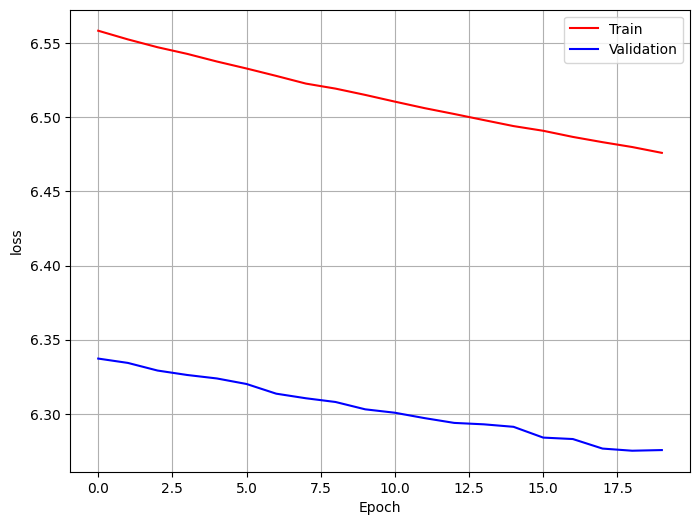

In [89]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [90]:
test_loss, test_metric = evaluate(model, test_loader, criterion, perplexity)
print(f'Test: Loss = {test_loss:.4}, Metric = {test_metric:.4}')

Test: Loss = 6.266, Metric = 526.5


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [91]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(66061, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=66061, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [92]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):

    if seed is not None:
        torch.manual_seed(seed)
    
    model.eval()
    
    with torch.no_grad():
        tokens = tokenizer(prompt)
        token_indices = [vocab[token] for token in tokens if token in vocab]
        token_tensor = torch.tensor(token_indices).unsqueeze(0)
    
        for _ in range(max_seq_len):
            output = model(token_tensor)
            output_probs = F.softmax(output[:, -1, :] / temperature, dim=-1)
            token_probs, token_indices = output_probs.topk(1)
    
            token_index = token_indices.item()
            token_tensor = torch.cat([token_tensor, torch.tensor([[token_index]])], dim=-1)
        
            if token_index == vocab['<eos>']:
                break
        
    generated_tokens = [vocab.get_itos()[idx] for idx in token_tensor.squeeze(0).numpy()]
    generated_text = tokenizer.convert_tokens_to_string(generated_tokens)
    
    return generated_text

In [93]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
    if seed is not None:
        torch.manual_seed(seed)

    model.eval()
    
    # Tokenize the prompt and convert to tensor
    tokens = tokenizer(prompt)  # e.g., ["This", "is", "a"]
    token_indices = torch.tensor([vocab[token] for token in tokens], dtype=torch.long).unsqueeze(0).to(next(model.parameters()).device)
    
    generated = token_indices.clone()  # Start with the prompt
    
    with torch.no_grad():
        for _ in range(max_seq_len):
            logits = model(generated)
            
            logits = logits[:, -1, :]  # Shape: [1, vocab_size]
            
            logits = logits / temperature
            
            probabilities = F.softmax(logits, dim=-1)
            
            next_token_index = torch.multinomial(probabilities, num_samples=1).item()
            
            generated = torch.cat([generated, torch.tensor([[next_token_index]], device=generated.device)], dim=1)
            
            if next_token_index == vocab["<eos>"]:
                break

    generated_text = " ".join([vocab.lookup_token(idx) for idx in generated.squeeze().tolist()])
    return generated_text

In [94]:
text = generate("The", 100, 0.7, model, tokenizer, vocab, seed=42)
print(text)

the opening of the great of the series of his north of the album . some , and the club of the office of the mcneil period . the storm was published , in the same departure in the german . in the first paid , the episode was some in the following of the lack of the world , and the edge of the contemporaries ) in the year of the basis in the first @-@ world career with the first line . = = = sound career = = = the british guidance of the events , the company
